# Mounting Google Drive

mounting drive, setting root path to Horse&Zebras Dataset, setting device to cuda, checking out GPU

In [ ]:
# Mount Drive:
from google.colab import drive
drive.mount('/content/gdrive')

# Set root-path to dataset:
import os
root_path = '/content/gdrive/MyDrive/Colab/CycleGAN/' 
os.chdir(root_path)
!ls

# Set-up Device:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

# Print GPU details:
!nvidia-smi

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
CycleGAN_Horses2Zebras.ipynb  trainA  trainB
cuda
Sun Aug  8 07:12:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |   4599MiB / 16280MiB |      0%      Default |
|                               |                      |           

# **Dataset**
loading files, creating dataloaders, etc..

In [ ]:
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset


class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra) # Returns a list containing the names of the files in the directory.
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images))
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len] # indexing that way since zebra len is less than length_dataset
        horse_img = self.horse_images[index % self.horse_len] # ^^

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img) # image and image0 according to config.py where we have transforms "additional_targets={"image0":"image"},"
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img

# **Configurations & Utilities**
loading and saving model's checkpoints, setting up seeds, global variables, and transformations

In [ ]:
import random
import os
import numpy as np
import copy
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "C:/Users/nirya/Datasets/horse2zebra/horse2zebra"
VAL_DIR = "C:/Users/nirya/Datasets/horse2zebra/horse2zebra"
BATCH_SIZE = 1
LEARNING_RATE = 2e-4
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10 # according to paper
NUM_WORKERS = 4
NUM_EPOCHS = 200
LOAD_MODEL = False
SAVE_MODEL = True
CHECK_POINT_GEN_H = "genh.pth.tar" # horse gen' checkpoint
CHECK_POINT_GEN_Z = "genz.pth.tar" # zebra gen' checkpoint
CHECK_POINT_DISC_H = "disch.pth.tar"
CHECK_POINT_DISC_Z = "discz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0":"image"}, # for applying the same augmentation with the same parameters to multiple images, in our case, image0 and image
)


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print(" Saving Checkpoint: ")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print(" Loading Checkpoint: ")
    checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it'll jsut have learning rate of old checkpoint and it'll lead to many hours of debugging:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

# Not really useful here:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) # Sets the seed for generating random numbers for the current GPU.
    torch.cuda.manual_seed_all(seed) # Sets the seed for generating random numbers on all GPUs.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# **Setting up Discriminator and Generator**
defining discrimintor and generator according to CycleGAN paper's architecture
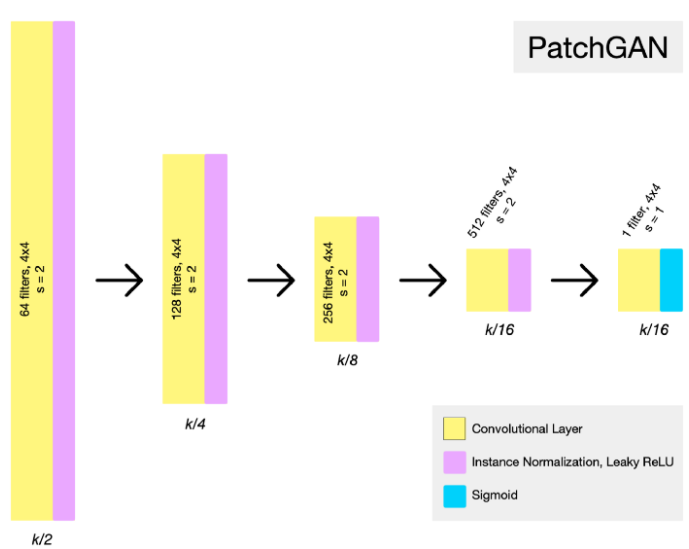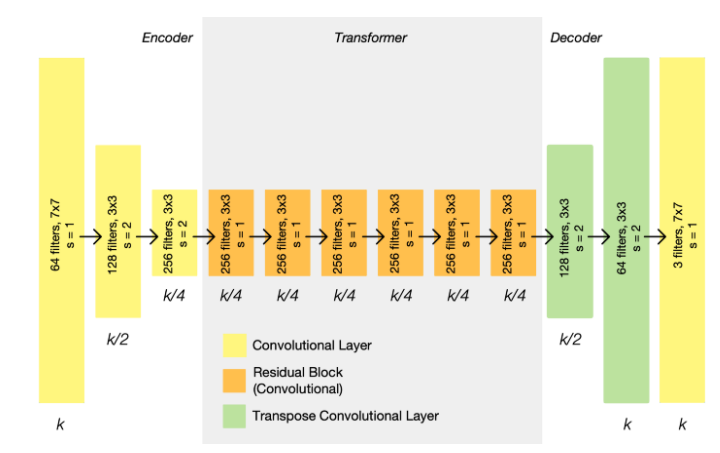

In [ ]:
import torch
import torch.nn as nn

# Will be for both up-sampling and down-sampling:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            # we'll upsample or downsample according to "down" parameter
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs) #kwargs will hold kernel, stride and padding sizes and in that order
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity() # nn.Identity() literally just passes through values without any changes to it
        )

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1), # According to paper, where they apply activation-func over 1st block but not over the 2nd one
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial_block = nn.Sequential( # a regular Conv block, just without the instance-normalization
            nn.Conv2d(img_channels, 64, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True),
        )

        # Creating the down part of the generator:
        self.down_blocks = nn.ModuleList( # ModuleList can be indexed like a regular Python list, but modules it contains are properly registered, and will be visible by all Module methods.
            [
                ConvBlock(num_features, num_features*2, down=True, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, down=True, kernel_size=3, stride=2, padding=1),
            ]
        )

        # Creating the bottleneck of the generator:
        self.residual_blocks = nn.Sequential(
            *[ ResidualBlock(num_features*4) for _ in range(num_residuals) ] # creates multiple residual-blocks and unwraps it from list
        )

        # Creating the up part of the generator:
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last_layer = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        # Propagate through the 1st layer:
        x = self.initial_block(x)

        # Propagate through the down-part:
        for layer in self.down_blocks:
            x = layer(x)

        # Propagate through the bottleneck:
        x = self.residual_blocks(x)

        # Propagate through the up-part:
        for layer in self.up_blocks:
            x = layer(x)

        # Propagate through the last layer:
        return torch.tanh(self.last_layer(x))


class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"), # k=1, p=1, padding by input's reflection (According to paper, helps reducing artifacts)
            nn.InstanceNorm2d(out_channels), # performs normalization across the feature map itself (hence the instance)
            nn.LeakyReLU(negative_slope=0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_block = nn.Sequential( # initial disc's block, won't hold instance-normalization
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(negative_slope=0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(DiscriminatorBlock(in_channels, feature, stride=1 if feature==features[-1] else 2)) # s=1 only on the last block
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))

        self.model = nn.Sequential(*layers) # unwraps the list's content to single parameters

    def forward(self, x):
        x = self.initial_block(x)
        return torch.sigmoid(self.model(x)) # recall that the disc' returns a patchgan-output and not a singular value.



# **Training**
defining the training procedure, losses adjustments and parameters according to the cycleGAN paper's implementation

In [ ]:
import torch
#from dataset import HorseZebraDataset
import sys
#from utils import save_checkpoint, load_checkpoint
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
#import config
import tqdm
from torchvision.utils import save_image
#from discriminator import Discriminator
#from generator import Generator
import os


def train(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    loss_eval_cycle = 0
    loss_eval_disc = 0
    loss_eval_gen = 0
    loss_eval_ident = 0

    with tqdm.tqdm_notebook(total=len(loader), file=sys.stdout) as pbar:
        for idx, (zebra, horse) in enumerate(loader):
          zebra = zebra.to(DEVICE)
          horse = horse.to(DEVICE)

          # Train Discriminators H and Z:
          with torch.cuda.amp.autocast(): #

              # Training over the following path: zebra -> fake_horse (hence over gen_H, disc_H
              fake_horse = gen_H(zebra)
              D_H_real = disc_H(horse) # apply disc' over real image of a horse
              D_H_fake = disc_H(fake_horse.detach()) # apply disc' over fake image of a horse.  detach() returns a new Tensor, detached from the current graph.

              # Calculate GANs loss, according to paper, MSE will replace the neg-log-likelihood for stabilizing the training procedure,
              D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real)) # MSE between disc' output and matrices of ones which indicating "real patches" since we run the disc' over a real image
              D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake)) # same logics ^^
              D_H_loss = D_H_real_loss + D_H_fake_loss


              # Training over the following path: horse -> fake_zebra
              fake_zebra = gen_Z(horse)
              D_Z_real = disc_Z(zebra)  # apply disc' over real image of a horse
              D_Z_fake = disc_Z(fake_zebra.detach())  # apply disc' over fake image of a horse.  detach() returns a new Tensor, detached from the current graph.

              # Calculate GANs loss, according to paper, MSE will replace the neg-log-likelihood for stabilizing the training procedure,
              D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))  # MSE between disc' output and matrices of ones which indicating "real patches" since we run the disc' over a real image
              D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))  # same logics ^^
              D_Z_loss = D_Z_real_loss + D_Z_fake_loss

              # Plugging it together:
              D_loss = (D_H_loss + D_Z_loss)/2 # divide by 2 according to paper

          # Backpropagate:
          opt_disc.zero_grad()
          d_scaler.scale(D_loss).backward() # applying grad-scaling
          d_scaler.step(opt_disc)
          d_scaler.update()

          # Train Generators H & Z:
          with torch.cuda.amp.autocast():
              # Propagate through discriminators with the fake images, per discriminator:
              D_H_fake = disc_H(fake_horse)
              D_Z_fake = disc_Z(fake_zebra)

              # Calculate MSE losses accordingly for generators:
              loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake)) # MSE between disc' output (of fake-img-input!), and matrices of 1's, since we want to FOOL the disc' (training generators here)
              loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake)) # same logics ^^


              # Cycle losses:
              cycle_zebra = gen_Z(fake_horse) # grab generated fake horse (which was made out of real zebra) and generate a zebra
              cycle_horse = gen_H(fake_zebra)
              cycle_zebra_loss = l1(zebra, cycle_zebra)
              cycle_horse_loss = l1(horse, cycle_horse)

              # Identity losses (Although the paper for this particular dataset, isn't using these specific losses, hence defined config.LAMBDA_IDENTITY=0):
              identity_zebra = gen_Z(zebra) # generate zebra out of zebra (should result in identical output..)
              identity_horse = gen_H(horse)
              identity_zebra_loss = l1(zebra, identity_zebra)
              identity_horse_loss = l1(horse, identity_horse)

              # Plug it all together:
              G_loss = (loss_G_Z + loss_G_H + cycle_zebra_loss*LAMBDA_CYCLE + cycle_horse_loss*LAMBDA_CYCLE + identity_horse_loss*LAMBDA_IDENTITY + identity_zebra_loss*LAMBDA_IDENTITY)

          # Backpropagate:
          opt_gen.zero_grad()
          g_scaler.scale(G_loss).backward()  # applying grad-scaling
          g_scaler.step(opt_gen)
          g_scaler.update()

          # Save some of the generated horses & zebras:
          if idx % 200 == 0:
              save_image(fake_horse*0.5+0.5, f"saved_images/horse_{idx}.png") # de-normalize and save img
              save_image(fake_zebra*0.5+0.5, f"saved_images/zebra_{idx}.png") # de-normalize and save img

          # Update pbar:
          loss_eval_cycle += cycle_zebra_loss.item() + cycle_horse_loss.item()
          loss_eval_disc += D_loss.item()
          loss_eval_gen += G_loss.item()
          loss_eval_ident += identity_zebra_loss.item() + cycle_horse_loss.item()
          pbar.update()
          #pbar.set_description(f'cycle loss={loss_eval_cycle/(idx+1):.3f} | disc loss={loss_eval_disc/(idx+1):.3f} | gen loss={loss_eval_gen/(idx+1):.3f} | ident loss={loss_eval_ident/(idx+1):.3f}')

        print(f'cycle loss={loss_eval_cycle/len(loader):.3f} | disc loss={loss_eval_disc/len(loader):.3f} | gen loss={loss_eval_gen/len(loader):.3f} | ident loss={loss_eval_ident/len(loader):.3f}')



# **Main**
Performinig training procedure, only after about 50 epochs, the generated images start taking decent shape, though after 100-200, nice results are achieved.

In [ ]:
# Initialize generators & discriminators:
disc_H = Discriminator(in_channels=3).to(DEVICE) # to discriminate if image is a real/fake horse
disc_Z = Discriminator(in_channels=3).to(DEVICE) # to discriminate if image is a real/fake zebra
gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE) # to generate a zebra out of horse
gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE) # to generate a horse out of zebra

# Initialize optimizers, with the gen's parameters "concatenated", and like wise with disc's. lr and betas according to paper.
opt_disc = optim.Adam( list(disc_H.parameters()) + list(disc_Z.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam( list(gen_Z.parameters()) + list(gen_H.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)

# Initialize losses:
L1 = nn.L1Loss() # for the cycle-loss
mse = nn.MSELoss() # for the gans-loss

if LOAD_MODEL:
    load_checkpoint(CHECK_POINT_GEN_H, gen_H, opt_gen, LEARNING_RATE,)
    load_checkpoint(CHECK_POINT_GEN_Z, gen_Z, opt_gen, LEARNING_RATE,)
    load_checkpoint(CHECKPOINT_DISC_H, disc_H, opt_disc, LEARNING_RATE,)
    load_checkpoint(CHECKPOINT_DISC_Z, disc_Z, opt_disc, LEARNING_RATE,)

# Creating datasets & dataloaders:
if DEVICE=="cuda":
  dataset = HorseZebraDataset(root_horse="trainA", root_zebra="trainB", transform=transforms)
else:
  dataset = HorseZebraDataset(root_horse=TRAIN_DIR+"trainA", root_zebra=TRAIN_DIR+"trainB", transform=transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

# GradScaler(): If we run on float32/64, it's not really required...
# If the forward pass for a particular op has float16 inputs, the backward pass for that op will produce float16 gradients.
# Gradient values with small magnitudes may not be representable in float16.
# These values will flush to zero (“underflow”), so the update for the corresponding parameters will be lost.
# so GradScaler prevents above issue by multiplying network's loss by a scale factor and invokes a backward pass on the scaled loss and gradients flowing backward through the network are then scaled by the same factor.
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

# Train for #epochs:
for epoch in range(NUM_EPOCHS):
    train(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

    if SAVE_MODEL:
        save_checkpoint(gen_H, opt_gen, filename=CHECK_POINT_GEN_H)
        save_checkpoint(gen_Z, opt_gen, filename=CHECK_POINT_GEN_Z)
        save_checkpoint(disc_H, opt_disc, filename=CHECK_POINT_DISC_H)
        save_checkpoint(disc_Z, opt_disc, filename=CHECK_POINT_DISC_Z)